In [ ]:
#dataset link("https://www.kaggle.com/datasets/aryashah2k/indian-medicinal-leaves-dataset")
#install the dataset from kaggle with thee provided link before running the code 

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Input,
    Conv2D, UpSampling2D, Add
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# === STEP 1: Prepare Combined Dataset ===
leaf_src = r'C:\Users\LENOVO\Downloads\capstone project\Medicinal Leaf dataset'
plant_src = r'C:\Users\LENOVO\Downloads\capstone project\Medicinal plant dataset'
combined_dir = r'C:\Users\LENOVO\Downloads\capstone project\combined data'
os.makedirs(combined_dir, exist_ok=True)

def copy_all_classes(src, dst):
    for folder in os.listdir(src):
        src_folder = os.path.join(src, folder)
        if os.path.isdir(src_folder):
            dst_folder = os.path.join(dst, folder.strip().lower().replace(" ", "_"))
            os.makedirs(dst_folder, exist_ok=True)
            for img in os.listdir(src_folder):
                full_path = os.path.join(src_folder, img)
                if os.path.isfile(full_path):
                    shutil.copy(full_path, os.path.join(dst_folder, img))

copy_all_classes(leaf_src, combined_dir)
copy_all_classes(plant_src, combined_dir)



KeyboardInterrupt: 

In [2]:
# === STEP 2: Create Datasets ===
batch_size = 32
img_size = (512,512)

train_ds = tf.keras.utils.image_dataset_from_directory(
    combined_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    combined_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"✅ Found {num_classes} classes.")

# === Prefetch for Performance ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 12813 files belonging to 98 classes.
Using 8970 files for training.
Found 12813 files belonging to 98 classes.
Using 3843 files for validation.
✅ Found 98 classes.


In [3]:
# === STEP 3: BiFPN ===
def bifpn_block(features, filters):
    p3, p4, p5 = features
    p3 = Conv2D(filters, 1, padding='same')(p3)
    p4 = Conv2D(filters, 1, padding='same')(p4)
    p5 = Conv2D(filters, 1, padding='same')(p5)
    p5_up = UpSampling2D()(p5)
    p4_td = Add()([p4, p5_up])
    p4_td = Conv2D(filters, 3, padding='same', activation='relu')(p4_td)
    p4_up = UpSampling2D()(p4_td)
    p3_td = Add()([p3, p4_up])
    p3_td = Conv2D(filters, 3, padding='same', activation='relu')(p3_td)
    return p3_td, p4_td, p5

# === STEP 4: Model ===
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(512,512, 3))
base_model.trainable = False

inputs = Input(shape=(512,512, 3))
p3 = base_model.get_layer('block4a_expand_activation').output
p4 = base_model.get_layer('block6a_expand_activation').output
p5 = base_model.get_layer('top_activation').output

p3, p4, p5 = bifpn_block([p3, p4, p5], filters=128)
p3_pool = GlobalAveragePooling2D()(p3)
p4_pool = GlobalAveragePooling2D()(p4)
p5_pool = GlobalAveragePooling2D()(p5)

x = Add()([p3_pool, p4_pool, p5_pool])
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)



In [2]:
# === STEP 5: Compile and Train ===
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(r"C:\Users\LENOVO\Downloads\capstone project\efficientnet_bifpn_80class.keras", save_best_only=True)
earlystop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint, earlystop]
)

model.save(r"C:\Users\LENOVO\Downloads\capstone project\efficientnet_bifpn_80class_final.keras")


NameError: name 'model' is not defined

**Evaluate on Validation Set and Collect Metrics**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm
from datetime import datetime

# Fix for the area display issue and improved GradCAM implementation

class GradCAM:
    def __init__(self, model, layer_name=None):
        """
        Initialize GradCAM with a model and target layer
        """
        self.model = model
        self.layer_name = layer_name
        
        # If no layer is specified, use the last convolutional layer
        if self.layer_name is None:
            for layer in reversed(self.model.layers):
                if isinstance(layer, tf.keras.layers.Conv2D):
                    self.layer_name = layer.name
                    break
        
        # Create a model that maps input to both the activations and the predictions
        self.grad_model = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[
                self.model.get_layer(self.layer_name).output,
                self.model.output
            ]
        )
    
    def _compute_heatmap(self, img_array, class_idx=None, eps=1e-8):
        """
        Generate a GradCAM heatmap for the specified class index
        """
        with tf.GradientTape() as tape:
            # Add batch dimension if needed
            if len(img_array.shape) == 3:
                img_array = tf.expand_dims(img_array, axis=0)
                
            # Cast to float32 for computation
            img_array = tf.cast(img_array, tf.float32)
            
            # Record operations for automatic differentiation
            tape.watch(img_array)
            
            # Get both the activations of the target layer and predictions
            conv_outputs, predictions = self.grad_model(img_array)
            
            # Determine prediction class if not specified
            if class_idx is None:
                class_idx = tf.argmax(predictions[0])
            
            # Extract the class score for the specified class
            class_channel = predictions[:, class_idx]
        
        # This is the gradient of the class score with respect to the target layer outputs
        grads = tape.gradient(class_channel, conv_outputs)
        
        # Pool the gradients over all the axes except the channel axis
        # This is more stable than just taking the mean
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight the output feature map with the gradients
        conv_outputs = conv_outputs[0]
        
        # Create the weighted feature map
        weighted_output = tf.multiply(pooled_grads, conv_outputs)
        
        # Average over channels to get the heatmap
        heatmap = tf.reduce_sum(weighted_output, axis=-1)
        
        # ReLU - only positive activations
        heatmap = tf.maximum(heatmap, 0)
        
        # Normalize the heatmap between 0 and 1
        max_val = tf.reduce_max(heatmap)
        if max_val != 0:
            heatmap = heatmap / max_val
        
        return heatmap.numpy()
    
    def detect_leaf_bounding_box(self, img):
        # Convert to RGB if not already
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
    
        if len(img.shape) != 3:
            # If grayscale, convert to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img.copy()
    
        # Convert to HSV color space for better color segmentation
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
        # Define range for green color (adjust these values based on your dataset)
        # These are sample values for green leaves
        lower_green = np.array([25, 40, 40])
        upper_green = np.array([90, 255, 255])
    
        # Create a mask for green regions
        mask = cv2.inRange(img_hsv, lower_green, upper_green)
    
        # Apply morphological operations to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
        # Dilate to ensure we capture the entire leaf
        mask = cv2.dilate(mask, kernel, iterations=1)
    
        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # If no contours found, try alternative method with Otsu thresholding
        if not contours:
        # Convert to LAB color space for better leaf/background separation
            img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        
            # Extract the 'a' channel (green-red)
            a_channel = img_lab[:,:,1]
        
            # Apply Gaussian blur
            blurred = cv2.GaussianBlur(a_channel, (5, 5), 0)
        
            # Apply Otsu's thresholding
            _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
            # Apply morphological operations
            kernel = np.ones((5, 5), np.uint8)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter contours by area to avoid noise
        min_area = 100  # Minimum contour area to consider
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
        # If no valid contours found, return the whole image dimensions
        if not valid_contours:
            return (0, 0, img.shape[1], img.shape[0]), None
        # Get the largest contour (assuming it's the leaf)
        largest_contour = max(valid_contours, key=cv2.contourArea)
    
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(largest_contour)
    
        # Add a small margin to the bounding box
        margin = 5
        x = max(0, x - margin)
        y = max(0, y - margin)
        w = min(img.shape[1] - x, w + 2 * margin)
        h = min(img.shape[0] - y, h + 2 * margin)
    
        return (x, y, w, h), largest_contour
    
    def add_text_with_background(self, img, text, position, font_scale=0.7, 
                                thickness=2, text_color=(255, 255, 255), 
                                bg_color=(0, 0, 0), padding=5):
        """
        Add text with background to an image
        """
        # Get text size
        (text_width, text_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        
        # Calculate background rectangle
        x, y = position
        bg_rect = [
            x - padding, 
            y - text_height - padding - baseline, 
            x + text_width + padding, 
            y + padding
        ]
        
        # Draw background rectangle
        cv2.rectangle(img, 
                     (bg_rect[0], bg_rect[1]), 
                     (bg_rect[2], bg_rect[3]), 
                     bg_color, -1)
        
        # Draw text
        cv2.putText(img, text, (x, y - baseline), 
                   cv2.FONT_HERSHEY_SIMPLEX, font_scale, 
                   text_color, thickness)
        
        return img
    
    def generate_and_overlay_heatmap(self, img_path, class_idx=None, alpha=0.4):
        """
        Load an image, generate heatmap, and overlay it on the original image with bounding box
        """
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(512,512))
        img_array = image.img_to_array(img)
        
        # Process for model input
        model_input = tf.keras.applications.efficientnet.preprocess_input(img_array.copy())
        
        # Make prediction if class index is not provided
        preds = None
        if class_idx is None:
            preds = self.model.predict(np.expand_dims(model_input, axis=0))
            class_idx = np.argmax(preds[0])
            class_confidence = preds[0][class_idx]
            print(f"Predicted class: {class_names[class_idx]} with confidence: {class_confidence:.4f}")
        else:
            # Still need confidence for display
            preds = self.model.predict(np.expand_dims(model_input, axis=0))
            class_confidence = preds[0][class_idx]
        
        # Compute heatmap
        heatmap = self._compute_heatmap(model_input, class_idx)
        
        # Resize heatmap to match original image size
        heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
        
        # Convert heatmap to RGB format
        heatmap_colored = np.uint8(255 * heatmap)
        heatmap_colored = cm.jet(heatmap_colored)[:, :, :3] * 255
        heatmap_colored = np.uint8(heatmap_colored)
        
        # Convert original image to BGR (for OpenCV)
        img_bgr = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2BGR)
        
        # Overlay heatmap on original image
        superimposed_img = cv2.addWeighted(img_bgr, 1-alpha, heatmap_colored, alpha, 0)
        
        # Detect leaf and get bounding box
        (x, y, w, h), contour = self.detect_leaf_bounding_box(img_array.astype('uint8'))
        
        # Draw bounding box on the original image copy
        img_with_bbox = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2BGR).copy()
        cv2.rectangle(img_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Add a side panel for information
        class_name = class_names[class_idx]
        conf_text = f"{class_confidence:.2f}"
        
        # Calculate leaf metrics
        leaf_area = 0
        if contour is not None:
            leaf_area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * leaf_area / (perimeter * perimeter) if perimeter > 0 else 0
        else:
            perimeter = 0
            circularity = 0
        
        # Side panel position
        panel_x = img_with_bbox.shape[1] - 230  # Right side of image
        panel_y = 30
        line_height = 30
        
        # Add info to side panel with fixed formatting - FIX for ?? in area
        labels = [
            f"Class: {class_name}",
            f"Conf: {conf_text}",
            f"Area: {int(leaf_area)}px",  # Format as integer to avoid ?? 
            f"Perim: {int(perimeter)}px",
            f"Circ: {circularity:.2f}"
        ]
        
        for i, label in enumerate(labels):
            img_with_bbox = self.add_text_with_background(
                img_with_bbox,
                label,
                (panel_x, panel_y + i * line_height),
                bg_color=(0, 100, 0)
            )
        
        # Draw the same side panel on superimposed image
        for i, label in enumerate(labels):
            superimposed_img = self.add_text_with_background(
                superimposed_img,
                label,
                (panel_x, panel_y + i * line_height),
                bg_color=(0, 100, 0)
            )
        
        # If contour is available, draw it
        if contour is not None:
            cv2.drawContours(superimposed_img, [contour], 0, (255, 0, 0), 2)
            cv2.drawContours(img_with_bbox, [contour], 0, (255, 0, 0), 2)
        
        # Convert back to RGB for display
        superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        img_with_bbox = cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB)
        
        return img_array.astype('uint8'), heatmap, superimposed_img, img_with_bbox, class_idx, (x, y, w, h), class_confidence
    
    def plot_results(self, img_path, class_idx=None, save_dir=None, figsize=(12, 10)):
        """
        Plot the results in a 2x2 grid and optionally save the images
        """
        img, heatmap, overlaid_img, img_with_bbox, predicted_class, bbox, confidence = self.generate_and_overlay_heatmap(img_path, class_idx)
        
        # Create figure with 2x2 grid
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        
        # Plot original image (top-left)
        axs[0, 0].imshow(img)
        axs[0, 0].set_title('Original Image')
        axs[0, 0].axis('off')
        
        # Plot image with bounding box and class info (top-right)
        axs[0, 1].imshow(img_with_bbox)
        axs[0, 1].set_title('Leaf Detection & Classification')
        axs[0, 1].axis('off')
        
        # Plot heatmap (bottom-left)
        axs[1, 0].imshow(heatmap, cmap='jet')
        axs[1, 0].set_title('GradCAM Heatmap')
        axs[1, 0].axis('off')
        
        # Plot overlaid image with bounding box (bottom-right)
        axs[1, 1].imshow(overlaid_img)
        axs[1, 1].set_title(f'Prediction: {class_names[predicted_class]} ({confidence:.2f})')
        axs[1, 1].axis('off')
        
        plt.tight_layout()
        
        # Save the figure if save_dir is provided
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            
            # Create filename with timestamp and class name
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            base_filename = os.path.basename(img_path).split('.')[0]
            class_name = class_names[predicted_class].replace(' ', '_')
            
            # Save combined figure only
            fig_path = os.path.join(save_dir, f"{base_filename}_{class_name}_{timestamp}_combined.png")
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Combined figure saved to: {fig_path}")
        
        plt.show()
        
        return predicted_class, bbox, confidence

# Example usage:
def test_gradcam(model_path, test_image_path, save_dir=None):
    """
    Test GradCAM visualization on a sample image and optionally save results
    """
    # Load trained model
    model = load_model(model_path)
    
    # Initialize GradCAM - we'll use the final activation layer before the global pooling
    gradcam = GradCAM(model, layer_name="top_activation")
    
    # Visualize GradCAM results
    predicted_class, bbox, confidence = gradcam.plot_results(test_image_path, save_dir=save_dir)
    
    print(f"Predicted class: {class_names[predicted_class]} with confidence: {confidence:.4f}")
    print(f"Detected leaf bounding box: x={bbox[0]}, y={bbox[1]}, width={bbox[2]}, height={bbox[3]}")
    
    if save_dir:
        print(f"Results saved to: {save_dir}")
    
    return predicted_class, bbox, confidence

# Create a function to batch process multiple test images
def process_test_images(model_path, test_image_folder, save_dir=None, num_samples=5):
    """
    Process multiple test images and display GradCAM results in 2x2 grid layout
    """
    model = load_model(model_path)
    gradcam = GradCAM(model, layer_name="top_activation")
    
    # Get list of images from the test folder
    image_files = []
    for class_folder in os.listdir(test_image_folder):
        class_path = os.path.join(test_image_folder, class_folder)
        if os.path.isdir(class_path):
            files = [os.path.join(class_path, f) for f in os.listdir(class_path)[:num_samples]]
            image_files.extend(files)
    
    # Process a limited number of images
    samples = min(len(image_files), num_samples)
    results = []
    
    for i in range(samples):
        print(f"\nProcessing image {i+1}/{samples}")
        predicted_class, bbox, confidence = gradcam.plot_results(image_files[i], save_dir=save_dir)
        results.append({
            'image_path': image_files[i],
            'predicted_class': class_names[predicted_class],
            'confidence': confidence,
            'bounding_box': bbox
        })
    
    return results

# Advanced function to analyze leaf characteristics
def analyze_leaf_characteristics(img_path, bbox=None):
    """
    Analyze leaf characteristics like shape, color and texture
    """
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # If no bounding box provided, detect one
    if bbox is None:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            bbox = cv2.boundingRect(largest_contour)
        else:
            bbox = (0, 0, img.shape[1], img.shape[0])
    
    x, y, w, h = bbox
    leaf_region = img[y:y+h, x:x+w]
    
    # Color analysis (average RGB)
    avg_color = np.mean(leaf_region, axis=(0, 1))
    
    # Shape analysis
    gray_leaf = cv2.cvtColor(leaf_region, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray_leaf, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    leaf_area = np.sum(binary > 0)
    bbox_area = w * h
    filling_ratio = leaf_area / bbox_area
    
    # Contour-based measurements
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
    else:
        perimeter = 0
        area = 0
        circularity = 0
    
    results = {
        'avg_color_rgb': avg_color,
        'leaf_area': leaf_area,
        'filling_ratio': filling_ratio,
        'perimeter': perimeter,
        'circularity': circularity
    }
    
    return results

# Function to predict and analyze a leaf image
def predict_and_analyze_leaf(model_path, img_path, save_dir=None):
    """
    Make a prediction, visualize with GradCAM, and analyze leaf characteristics
    """
    # Load the model
    model = load_model(model_path)
    
    # Initialize GradCAM
    gradcam = GradCAM(model, layer_name="top_activation")
    
    # Get prediction and bounding box, and save results if requested
    predicted_class, bbox, confidence = gradcam.plot_results(img_path, save_dir=save_dir)
    
    # Analyze leaf characteristics
    leaf_analysis = analyze_leaf_characteristics(img_path, bbox)
    
    print("\nLeaf Analysis Results:")
    print(f"Predicted class: {class_names[predicted_class]} with confidence: {confidence:.4f}")
    print(f"Average RGB color: R={leaf_analysis['avg_color_rgb'][0]:.1f}, G={leaf_analysis['avg_color_rgb'][1]:.1f}, B={leaf_analysis['avg_color_rgb'][2]:.1f}")
    print(f"Leaf area: {leaf_analysis['leaf_area']} pixels")
    print(f"Filling ratio: {leaf_analysis['filling_ratio']:.2f}")
    print(f"Circularity: {leaf_analysis['circularity']:.2f} (1.0 is a perfect circle)")
    
    return predicted_class, bbox, confidence, leaf_analysis

# Example usage:
# 1. Test GradCAM with side labels on a single image and save results
save_dir = r"C:\Users\LENOVO\Downloads\capstone project\det_output"
test_gradcam(r"C:\Users\LENOVO\Downloads\capstone project\efficientnet_bifpn_80class.keras", 
             r"C:\Users\LENOVO\Downloads\capstone project\Medicinal Leaf dataset\Tulsi\20190822_173642.jpg",save_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


NameError: name 'class_names' is not defined

In [10]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gradio (from versions: none)
ERROR: No matching distribution found for gradio

[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 12813 files belonging to 98 classes.
Using 3843 files for validation.
Number of classes: 98

Classification Report:
                         precision    recall  f1-score   support

               aloevera       0.96      0.99      0.98        83
                   amla       0.84      0.98      0.91        65
           amruta_balli       0.97      0.84      0.90        38
           amruthaballi       0.93      0.96      0.95        28
                  arali       1.00      1.00      1.00        71
                 ashoka       1.00      0.98      0.99        59
            ashwagandha       0.98      0.98      0.98        51
             astma_weed       1.00      0.96      0.98        26
                avacado       1.00      0.93      0.97        45
               badipala       1.00      0.94      0.97        18
           balloon_vine       1.00      0.86      0.93        22
                 bamboo       0.99      1.00      0.99        80
                 basale       0.

<Figure size 2000x2000 with 0 Axes>

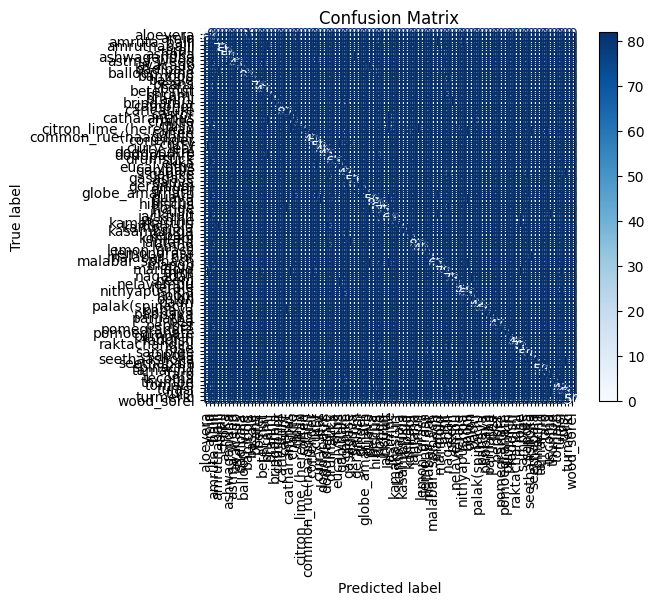

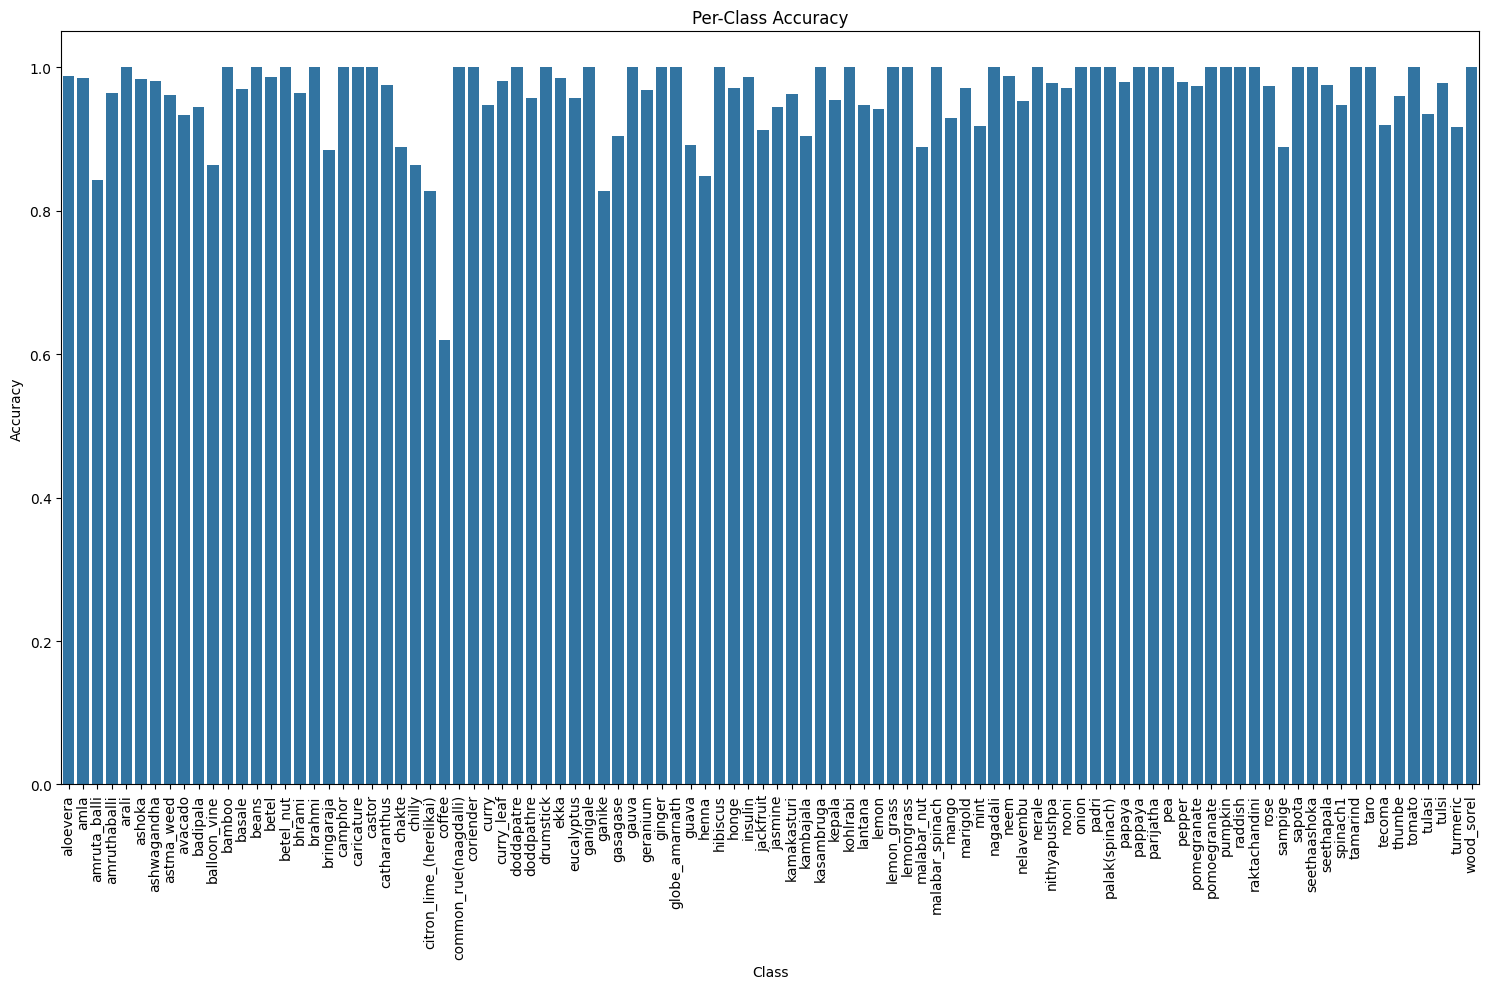

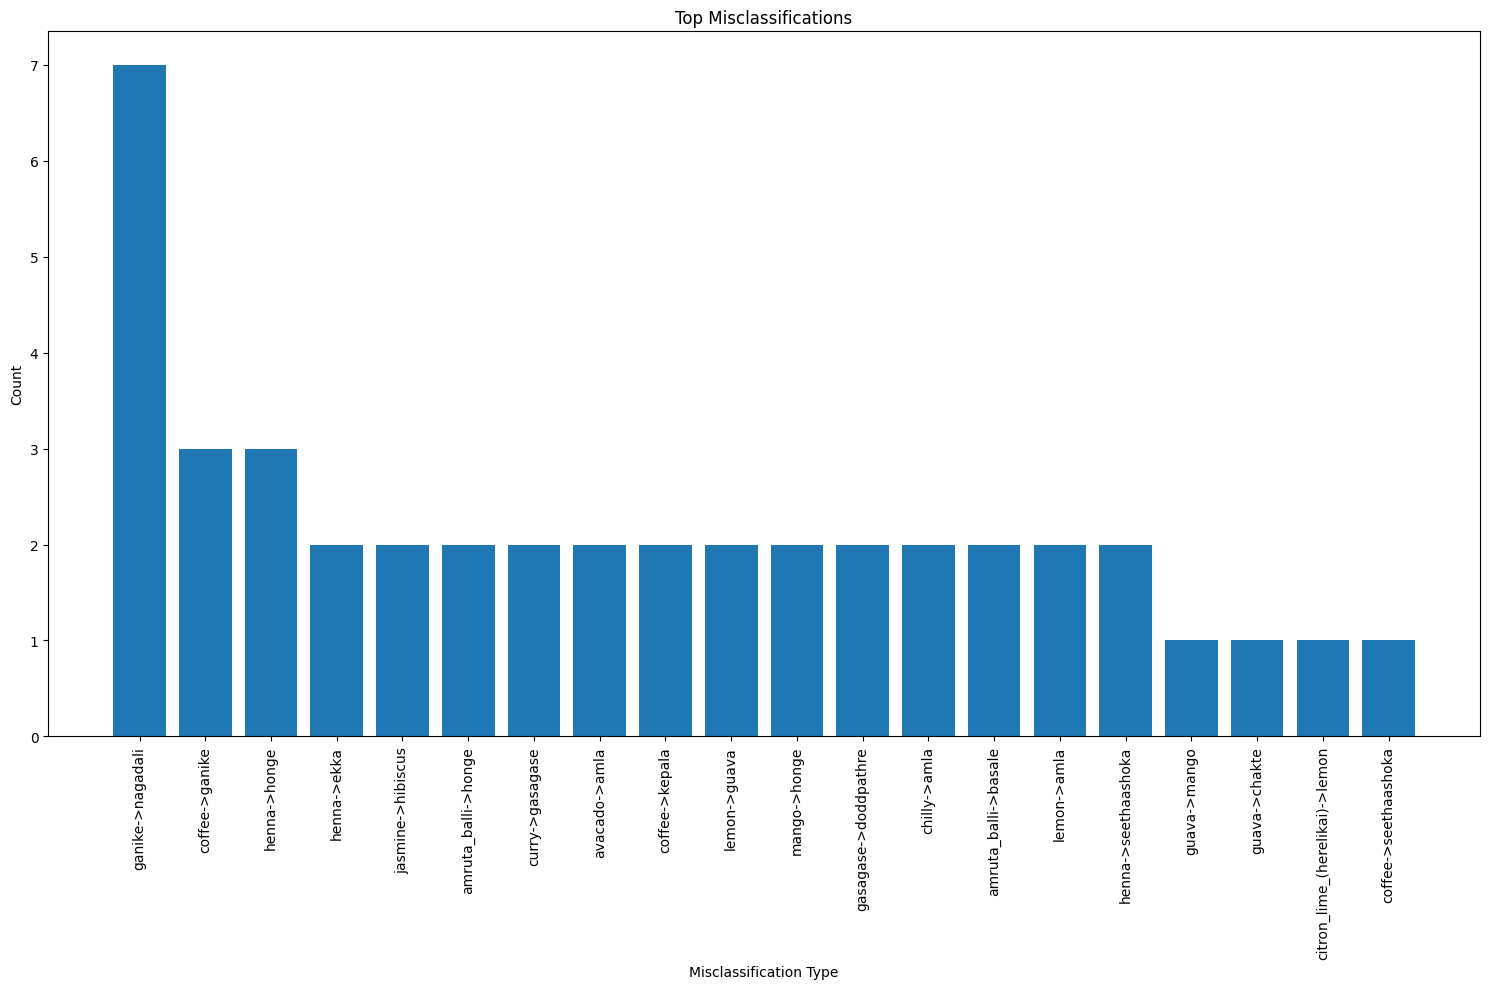


Overall Accuracy: 0.9651

Classes with lowest accuracy:
coffee: 0.6190
ganike: 0.8269
citron_lime_(herelikai): 0.8276
amruta_balli: 0.8421
henna: 0.8485
balloon_vine: 0.8636
chilly: 0.8636
bringaraja: 0.8846
chakte: 0.8889
malabar_nut: 0.8889

Classes with highest accuracy:
arali: 1.0000
bamboo: 1.0000
beans: 1.0000
betel_nut: 1.0000
brahmi: 1.0000
camphor: 1.0000
caricature: 1.0000
castor: 1.0000
common_rue(naagdalli): 1.0000
coriender: 1.0000


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os

# Path to your saved model
model_path = r"C:\Users\LENOVO\Downloads\capstone project\efficientnet_bifpn_80class_final.keras"

# Load the validation dataset
combined_dir = r"C:\Users\LENOVO\Downloads\capstone project\combined data"
img_size = (512, 512)
batch_size = 32

val_ds = tf.keras.utils.image_dataset_from_directory(
    combined_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names
class_names = val_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Load the model
model = load_model(model_path)

# Generate predictions and true labels
y_true = []
y_pred = []
image_paths = []

# Create unbatched dataset to get individual images and labels
unbatched_ds = val_ds.unbatch()

for images, labels in unbatched_ds:
    # Get the image and its true label
    image = images.numpy()
    true_label = labels.numpy()
    
    # Make prediction
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    
    # Store results
    y_true.append(true_label)
    y_pred.append(pred_label)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title('Confusion Matrix')
plt.savefig(r'C:\Users\LENOVO\Downloads\capstone project\combined data\confusion_matrix.png', bbox_inches='tight')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot class accuracy
plt.figure(figsize=(15, 10))
sns.barplot(x=np.arange(len(class_names)), y=class_accuracy)
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.savefig(r'C:\Users\LENOVO\Downloads\capstone project\combined data\class_accuracy.png', bbox_inches='tight')
plt.show()

# Calculate and plot top misclassifications
misclassification_counts = {}
for true_idx, pred_idx in zip(y_true, y_pred):
    if true_idx != pred_idx:
        key = (class_names[true_idx], class_names[pred_idx])
        misclassification_counts[key] = misclassification_counts.get(key, 0) + 1

# Sort misclassifications by count
sorted_misclassifications = sorted(misclassification_counts.items(), key=lambda x: x[1], reverse=True)

# Plot top N misclassifications
top_n = min(20, len(sorted_misclassifications))
top_misclassifications = sorted_misclassifications[:top_n]

plt.figure(figsize=(15, 10))
plt.bar(range(top_n), [count for _, count in top_misclassifications])
plt.xticks(range(top_n), [f"{true}->{pred}" for (true, pred), _ in top_misclassifications], rotation=90)
plt.xlabel('Misclassification Type')
plt.ylabel('Count')
plt.title('Top Misclassifications')
plt.tight_layout()
plt.savefig(r'C:\Users\LENOVO\Downloads\capstone project\top_misclassifications.png', bbox_inches='tight')
plt.show()

# Calculate overall metrics
overall_accuracy = np.mean(y_true == y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Identify classes with the lowest accuracy
class_acc_with_names = [(class_names[i], acc) for i, acc in enumerate(class_accuracy)]
lowest_accuracy_classes = sorted(class_acc_with_names, key=lambda x: x[1])[:10]

print("\nClasses with lowest accuracy:")
for class_name, acc in lowest_accuracy_classes:
    print(f"{class_name}: {acc:.4f}")

# Identify classes with the highest accuracy
highest_accuracy_classes = sorted(class_acc_with_names, key=lambda x: x[1], reverse=True)[:10]

print("\nClasses with highest accuracy:")
for class_name, acc in highest_accuracy_classes:
    print(f"{class_name}: {acc:.4f}")

In [6]:
pip install gradio

     ---------------------------------------- 54.1/54.1 MB 7.0 MB/s eta 0:00:00
     -------------------------------------- 100.9/100.9 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 kB 5.3 MB/s eta 0:00:00
     -------------------------------------- 322.9/322.9 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 73.5/73.5 kB ? eta 0:00:00
     ------------------------------------ 134.6/134.6 kB 797.2 kB/s eta 0:00:00
     ---------------------------------------- 11.6/11.6 MB 6.5 MB/s eta 0:00:00
     -------------------------------------- 72.0/72.0 kB 657.4 kB/s eta 0:00:00
     -------------------------------------- 45.3/45.3 kB 448.9 kB/s eta 0:00:00
     ---------------------------------------- 62.5/62.5 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 176.8/176.8 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 78.8/78.8 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 9


[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import gradio as gr
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm
from PIL import Image, ImageDraw, ImageFont
import io
import base64

# Load the model
model_path = r"C:\Users\LENOVO\Downloads\capstone project\efficientnet_bifpn_80class_final.keras"
model = load_model(model_path)

# Define class names (these should match your actual class names from training)
class_names = [
    'aloevera', 'amla', 'amruta_balli', 'amruthaballi', 'arali', 'ashoka', 
    'ashwagandha', 'astma_weed', 'avacado', 'badipala', 'balloon_vine', 'bamboo', 
    'basale', 'beans', 'betel', 'betel_nut', 'bhrami', 'brahmi', 'bringaraja', 
    'camphor', 'caricature', 'castor', 'catharanthus', 'chakte', 'chilly', 
    'citron_lime_(herelikai)', 'coffee', 'common_rue(naagdalli)', 'coriender', 'curry', 
    'curry_leaf', 'doddapatre', 'doddpathre', 'drumstick', 'ekka', 'eucalyptus', 
    'ganigale', 'ganike', 'gasagase', 'gauva', 'geranium', 'ginger', 'globe_amarnath', 
    'guava', 'henna', 'hibiscus', 'honge', 'insulin', 'jackfruit', 'jasmine', 
    'kamakasturi', 'kambajala', 'kasambruga', 'kepala', 'kohlrabi', 'lantana', 
    'lemon', 'lemon_grass', 'lemongrass', 'malabar_nut', 'malabar_spinach', 'mango', 
    'marigold', 'mint', 'nagadali', 'neem', 'nelavembu', 'nerale', 'nithyapushpa', 
    'nooni', 'onion', 'padri', 'palak(spinach)', 'papaya', 'pappaya', 'parijatha', 
    'pea', 'pepper', 'pomegranate', 'pomoegranate', 'pumpkin', 'raddish', 
    'raktachandini', 'rose', 'sampige', 'sapota', 'seethaashoka', 'seethapala', 
    'spinach1', 'tamarind', 'taro', 'tecoma', 'thumbe', 'tomato', 'tulasi', 'tulsi', 
    'turmeric', 'wood_sorel'
]

# Load therapeutic information
def load_therapeutic_info():
    # CSV file path - adjust according to your file location
    csv_path = r"C:\Users\LENOVO\Downloads\capstone project\medicinal_leaf_98_full_v19.csv"
    try:
        df = pd.read_csv(csv_path)
        # Create a dictionary with class name as key
        therapeutic_info = {}
        for _, row in df.iterrows():
            common_name = row.get('Common Name', '').lower().strip()
            if common_name in class_names:
                therapeutic_info[common_name] = {
                    'scientific_name': row.get('Scientific Name', 'N/A'),
                    'local_names': row.get('Alternate/Local Names', 'N/A'),
                    'therapeutic_uses': row.get('Therapeutic Uses', 'No information available'),
                    'preparation': row.get('Preparation', 'No information available'),
                    'caution': row.get('Caution', 'No specific cautions noted')
                }
        return therapeutic_info
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return {}

therapeutic_info = load_therapeutic_info()

# GradCAM implementation
class GradCAM:
    def __init__(self, model, layer_name=None):
        self.model = model
        self.layer_name = layer_name
        
        if self.layer_name is None:
            for layer in reversed(self.model.layers):
                if isinstance(layer, tf.keras.layers.Conv2D):
                    self.layer_name = layer.name
                    break
        
        self.grad_model = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[
                self.model.get_layer(self.layer_name).output,
                self.model.output
            ]
        )
    
    def _compute_heatmap(self, img_array, class_idx=None, eps=1e-8):
        with tf.GradientTape() as tape:
            if len(img_array.shape) == 3:
                img_array = tf.expand_dims(img_array, axis=0)
                
            img_array = tf.cast(img_array, tf.float32)
            tape.watch(img_array)
            
            conv_outputs, predictions = self.grad_model(img_array)
            
            if class_idx is None:
                class_idx = tf.argmax(predictions[0])
            
            class_channel = predictions[:, class_idx]
        
        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        conv_outputs = conv_outputs[0]
        weighted_output = tf.multiply(pooled_grads, conv_outputs)
        
        heatmap = tf.reduce_sum(weighted_output, axis=-1)
        heatmap = tf.maximum(heatmap, 0)
        
        max_val = tf.reduce_max(heatmap)
        if max_val != 0:
            heatmap = heatmap / max_val
        
        return heatmap.numpy()
    
    def detect_leaf_bounding_box(self, img):
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
    
        if len(img.shape) != 3:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img.copy()
    
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
        lower_green = np.array([25, 40, 40])
        upper_green = np.array([90, 255, 255])
    
        mask = cv2.inRange(img_hsv, lower_green, upper_green)
    
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
        mask = cv2.dilate(mask, kernel, iterations=1)
    
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        if not contours:
            img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
            a_channel = img_lab[:,:,1]
            blurred = cv2.GaussianBlur(a_channel, (5, 5), 0)
            _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        min_area = 100
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
        if not valid_contours:
            return (0, 0, img.shape[1], img.shape[0]), None
            
        largest_contour = max(valid_contours, key=cv2.contourArea)
    
        x, y, w, h = cv2.boundingRect(largest_contour)
    
        margin = 5
        x = max(0, x - margin)
        y = max(0, y - margin)
        w = min(img.shape[1] - x, w + 2 * margin)
        h = min(img.shape[0] - y, h + 2 * margin)
    
        return (x, y, w, h), largest_contour
    
    def generate_overlay_heatmap(self, img_path_or_array):
        if isinstance(img_path_or_array, str):
            img = image.load_img(img_path_or_array, target_size=(512, 512))
            img_array = image.img_to_array(img)
        else:
            # Resize if necessary
            if img_path_or_array.shape[:2] != (512, 512):
                img_path_or_array = cv2.resize(img_path_or_array, (512, 512))
            img_array = img_path_or_array
            if len(img_array.shape) == 2:  # Grayscale
                img_array = np.stack((img_array,) * 3, axis=-1)
        
        # Process for model input
        model_input = tf.keras.applications.efficientnet.preprocess_input(img_array.copy())
        
        # Make prediction
        preds = self.model.predict(np.expand_dims(model_input, axis=0))
        class_idx = np.argmax(preds[0])
        class_confidence = preds[0][class_idx]
        
        # Compute heatmap
        heatmap = self._compute_heatmap(model_input, class_idx)
        
        # Resize heatmap to match original image size
        heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
        
        # Convert heatmap to RGB format
        heatmap_colored = np.uint8(255 * heatmap)
        heatmap_colored = cm.jet(heatmap_colored)[:, :, :3] * 255
        heatmap_colored = np.uint8(heatmap_colored)
        
        # Convert original image to BGR (for OpenCV)
        img_bgr = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2BGR)
        
        # Overlay heatmap on original image
        superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap_colored, 0.4, 0)
        
        # Detect leaf and get bounding box
        (x, y, w, h), contour = self.detect_leaf_bounding_box(img_array.astype('uint8'))
        
        # Draw bounding box on the superimposed image
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # If contour is available, draw it
        if contour is not None:
            cv2.drawContours(superimposed_img, [contour], 0, (255, 0, 0), 2)
        
        # Convert back to RGB for display
        result_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        
        # Calculate leaf metrics
        leaf_area = 0
        if contour is not None:
            leaf_area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * leaf_area / (perimeter * perimeter) if perimeter > 0 else 0
        else:
            perimeter = 0
            circularity = 0
            
        leaf_metrics = {
            "area": int(leaf_area),
            "perimeter": int(perimeter),
            "circularity": round(circularity, 2)
        }
        
        return result_img, class_names[class_idx], class_confidence, leaf_metrics

# Function to predict and get therapeutic info
def predict_leaf(image):
    if image is None:
        return None, "Please upload an image."
    
    # Initialize GradCAM
    gradcam = GradCAM(model, layer_name="top_activation")
    
    # Convert to numpy array if needed
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image
        
    # Process image with GradCAM
    processed_image, class_name, confidence, leaf_metrics = gradcam.generate_overlay_heatmap(image_np)
    
    # Get therapeutic information
    info = therapeutic_info.get(class_name, {})
    scientific_name = info.get('scientific_name', 'Information not available')
    local_names = info.get('local_names', 'Information not available')
    therapeutic_uses = info.get('therapeutic_uses', 'Information not available')
    preparation = info.get('preparation', 'Information not available')
    caution = info.get('caution', 'Information not available')
    
    # Format the combined results HTML
    combined_html = f"""
    <div class="results-container">
        <div class="results-section">
            <div class="identification-card">
                <div class="card-header">
                    <h3>Identification Results</h3>
                </div>
                <div class="card-content">
                    <div class="result-item">
                        <span class="label">Identified Plant:</span>
                        <span class="value">{class_name.replace('_', ' ').title()}</span>
                    </div>
                    <div class="result-item">
                        <span class="label">Confidence:</span>
                        <span class="value">{confidence:.2%}</span>
                        <div class="confidence-bar">
                            <div class="confidence-fill" style="width: {confidence*100}%;"></div>
                        </div>
                    </div>
                    <div class="result-item">
                        <span class="label">Scientific Name:</span>
                        <span class="value italic">{scientific_name}</span>
                    </div>
                    <div class="result-item">
                        <span class="label">Local Names:</span>
                        <span class="value">{local_names}</span>
                    </div>
                    
                    <div class="metrics-section">
                        <h4>Leaf Metrics</h4>
                        <div class="metrics-grid">
                            <div class="metric-box">
                                <div class="metric-value">{leaf_metrics['area']}</div>
                                <div class="metric-label">Area (px²)</div>
                            </div>
                            <div class="metric-box">
                                <div class="metric-value">{leaf_metrics['perimeter']}</div>
                                <div class="metric-label">Perimeter (px)</div>
                            </div>
                            <div class="metric-box">
                                <div class="metric-value">{leaf_metrics['circularity']}</div>
                                <div class="metric-label">Circularity</div>
                            </div>
                        </div>
                    </div>
                </div>
            </div>
        </div>
        
        <div class="results-section">
            <div class="therapeutic-card">
                <div class="card-header">
                    <h3>Therapeutic Information</h3>
                </div>
                <div class="card-content">
                    <div class="therapeutic-section">
                        <h4>Therapeutic Uses</h4>
                        <p class="therapeutic-text">{therapeutic_uses}</p>
                    </div>
                    <div class="therapeutic-section">
                        <h4>Preparation Methods</h4>
                        <p class="therapeutic-text">{preparation}</p>
                    </div>
                    <div class="caution-box">
                        <div class="caution-header">
                            <svg xmlns="http://www.w3.org/2000/svg" width="24" height="24" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2" stroke-linecap="round" stroke-linejoin="round">
                                <path d="M10.29 3.86L1.82 18a2 2 0 0 0 1.71 3h16.94a2 2 0 0 0 1.71-3L13.71 3.86a2 2 0 0 0-3.42 0z"></path>
                                <line x1="12" y1="9" x2="12" y2="13"></line>
                                <line x1="12" y1="17" x2="12.01" y2="17"></line>
                            </svg>
                            <h4>Cautions</h4>
                        </div>
                        <p class="caution-text">{caution}</p>
                    </div>
                </div>
            </div>
        </div>
    </div>
    """
    
    return processed_image, combined_html

# Custom CSS for the unified interface
custom_css = """
:root {
    --primary: #2D7D46;
    --primary-light: #E3F2E7;
    --accent: #FFC107;
    --text-dark: #2C3E50;
    --text-light: #7F8C8D;
    --text-therapeutic: #333333;  /* Darker text for better visibility */
    --danger: #E74C3C;
    --danger-light: #FDEDEC;
    --radius: 12px;
    --shadow: 0 4px 6px rgba(0,0,0,0.05), 0 1px 3px rgba(0,0,0,0.1);
}

body {
    font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
}

.container {
    max-width: 1200px;
    margin: 0 auto;
}

.app-header {
    background: linear-gradient(135deg, var(--primary), #1e5631);
    padding: 1.5rem;
    border-radius: var(--radius) var(--radius) 0 0;
    position: relative;
    overflow: hidden;
}

.app-header h1 {
    margin: 0;
    color: white;
    font-size: 1.8rem;
    font-weight: 700;
    letter-spacing: -0.5px;
}

.app-header p {
    color: rgba(255, 255, 255, 0.8);
    margin: 0.5rem 0 0;
    font-size: 1rem;
    max-width: 80%;
}

.header-decoration {
    position: absolute;
    right: -50px;
    top: -20px;
    width: 200px;
    height: 200px;
    background: radial-gradient(circle at center, rgba(255,255,255,0.2) 0%, rgba(255,255,255,0) 70%);
    border-radius: 50%;
}

.app-footer {
    background-color: #f8f9fa;
    padding: 1rem;
    border-radius: 0 0 var(--radius) var(--radius);
    text-align: center;
    font-size: 0.85rem;
    color: var(--text-light);
    border-top: 1px solid #eaeaea;
}

.card {
    background: white;
    border-radius: var(--radius);
    box-shadow: var(--shadow);
    overflow: hidden;
    height: 100%;
}

.upload-container {
    background: white;
    border-radius: var(--radius);
    box-shadow: var(--shadow);
    overflow: hidden;
    height: 100%;
    padding: 0;
    /* Reduced height for upload box */
    max-height: 300px;
}

.card-header {
    padding: 1rem;
    background-color: var(--primary-light);
    border-bottom: 1px solid rgba(0,0,0,0.05);
}

.card-header h3 {
    margin: 0;
    color: var(--primary);
    font-size: 1.2rem;
    font-weight: 600;
}

.card-content {
    padding: 1rem;
}

.upload-section {
    display: flex;
    flex-direction: column;
    align-items: center;
    padding: 1.5rem;  /* Reduced padding */
    background-color: #f9fafc;
    border: 2px dashed #d1d5db;
    border-radius: var(--radius);
    cursor: pointer;
    transition: all 0.2s ease;
    /* Reduced height */
    max-height: 200px;
}

.upload-section:hover {
    border-color: var(--primary);
    background-color: var(--primary-light);
}

.upload-icon {
    font-size: 2rem;  /* Smaller icon */
    color: var(--primary);
    margin-bottom: 0.5rem;
}

.analyze-btn {
    width: 100%;
    padding: 0.75rem;
    margin-top: 1rem;
    background-color: var(--primary);
    color: white;
    font-weight: 600;
    border: none;
    border-radius: var(--radius);
    cursor: pointer;
    transition: all 0.2s ease;
}

.analyze-btn:hover {
    background-color: #236639;
    transform: translateY(-1px);
    box-shadow: 0 6px 12px rgba(0,0,0,0.1);
}

.analyze-btn:active {
    transform: translateY(0);
}

.result-image {
    width: 100%;
    border-radius: var(--radius);
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
}

.identification-card, .therapeutic-card {
    border-radius: var(--radius);
    background: white;
    box-shadow: var(--shadow);
    margin-bottom: 1.5rem;
    overflow: hidden;
}

.identification-card .card-header {
    background-color: #e3f2fd;
    border-bottom: 1px solid rgba(0,0,0,0.05);
}

.identification-card .card-header h3 {
    color: #1976d2;
}

.therapeutic-card .card-header {
    background-color: #e8f5e9;
    border-bottom: 1px solid rgba(0,0,0,0.05);
}

.therapeutic-card .card-header h3 {
    color: var(--primary);
}

.result-item {
    margin-bottom: 1rem;
    padding-bottom: 1rem;
    border-bottom: 1px solid #f0f0f0;
}

.result-item:last-child {
    border-bottom: none;
}

.label {
    display: block;
    font-size: 0.85rem;
    color: var(--text-light);
    margin-bottom: 0.25rem;
}

.value {
    font-weight: 500;
    color: var(--text-dark);
}

.italic {
    font-style: italic;
}

.confidence-bar {
    height: 6px;
    background-color: #eaeaea;
    border-radius: 3px;
    overflow: hidden;
    margin-top: 0.5rem;
}

.confidence-fill {
    height: 100%;
    background: linear-gradient(90deg, #4caf50, #8bc34a);
    border-radius: 3px;
}

.metrics-section {
    margin-top: 1.5rem;
}

.metrics-section h4 {
    margin: 0 0 1rem;
    color: var(--text-dark);
    font-size: 1rem;
    font-weight: 600;
}

.metrics-grid {
    display: flex;
    gap: 1rem;
}

.metric-box {
    flex: 1;
    background-color: #f8fafc;
    border-radius: 8px;
    padding: 1rem;
    text-align: center;
}

.metric-value {
    font-size: 1.5rem;
    font-weight: 600;
    color: var(--primary);
    margin-bottom: 0.25rem;
}

.metric-label {
    font-size: 0.8rem;
    color: var(--text-light);
}

.therapeutic-section {
    margin-bottom: 1.5rem;
}

.therapeutic-section h4 {
    margin: 0 0 0.75rem;
    font-size: 1rem;
    color: var(--primary);
}

/* Improved text visibility for therapeutic information */
.therapeutic-text {
    color: var(--text-therapeutic);
    font-weight: 500;
    line-height: 1.6;
}

.caution-box {
    background-color: var(--danger-light);
    border-radius: 8px;
    padding: 1rem;
}

.caution-header {
    display: flex;
    align-items: center;
    margin-bottom: 0.75rem;
}

.caution-header svg {
    color: var(--danger);
    margin-right: 0.5rem;
}

.caution-header h4 {
    margin: 0;
    color: var(--danger);
}

/* Improved text visibility for caution information */
.caution-text {
    color: #5A231F;
    font-weight: 500;
}

.loading-animation {
    display: none;
    text-align: center;
    padding: 2rem;
}

.loading-animation.active {
    display: block;
}

.spinner {
    width: 40px;
    height: 40px;
    margin: 0 auto 1rem;
    border: 4px solid rgba(0,0,0,0.1);
    border-radius: 50%;
    border-left-color: var(--primary);
    animation: spin 1s linear infinite;
}

@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}

/* New combined results container */
.results-container {
    display: flex;
    flex-direction: column;
    gap: 1.5rem;
}

.results-section {
    width: 100%;
}

/* Responsive styling */
@media (min-width: 768px) {
    .results-container {
        flex-direction: row;
        flex-wrap: wrap;
    }
    
    .results-section {
        flex: 1;
        min-width: 300px;
    }
}

@media (max-width: 768px) {
    .metrics-grid {
        flex-direction: column;
    }
    
    .app-header p {
        max-width: 100%;
    }
    
    .header-decoration {
        display: none;
    }
}
"""

# Create Gradio interface with the unified design
with gr.Blocks(css=custom_css) as demo:
    gr.HTML("""
    <div class="app-header">
        <div class="header-decoration"></div>
        <h1>Medicinal Leaf Analyzer</h1>
        <p>Upload an image of a medicinal leaf to identify it and learn about its therapeutic properties</p>
    </div>
    """)
    
    with gr.Row():
        with gr.Column(scale=1):
            # Smaller upload container
            with gr.Column(elem_classes=["upload-container"]):
                input_image = gr.Image(
                    label="Upload Leaf Image", 
                    type="numpy",
                    elem_classes=["upload-image"],
                    height=200  # Reduced height
                )
                submit_btn = gr.Button(
                    "Analyze Leaf", 
                    variant="primary",
                    elem_classes=["analyze-btn"]
                )
        
        with gr.Column(scale=2):
            # Output image for visualization
            output_image = gr.Image(
                label="Analysis Visualization",
                elem_classes=["result-image"]
            )
    
    # Combined outputs for identification and therapeutic info
    combined_results = gr.HTML(
        elem_id="combined-results"
    )
    
    gr.HTML("""
    <div class="app-footer">
        <p>Medicinal Leaf Analysis System | Powered by EfficientNet with BiFPN</p>
        <p><small>© 2025 - Plant Identification and Therapeutic Information System</small></p>
    </div>
    """)
    
    # Add loading animation with JavaScript
    gr.HTML("""
    <script>
    document.addEventListener('DOMContentLoaded', function() {
        const analyzeBtn = document.querySelector('.analyze-btn');
        
        if (analyzeBtn) {
            analyzeBtn.addEventListener('click', function() {
                analyzeBtn.textContent = 'Analyzing...';
                analyzeBtn.disabled = true;
                
                setTimeout(function() {
                    analyzeBtn.textContent = 'Analyze Leaf';
                    analyzeBtn.disabled = false;
                }, 100);
            });
        }
    });
    </script>
    """)
    
    submit_btn.click(
        fn=predict_leaf, 
        inputs=[input_image], 
        outputs=[output_image, combined_results]
    )
    
    demo.launch(share=True)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d3e1b993647a5b2e02.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


ERROR: Could not find a version that satisfies the requirement gradio (from versions: none)
ERROR: No matching distribution found for gradio
